# Load your dataset

Example data for one frame:
```
{
    "./sampledFrames/test_video/13260.jpg": 
    {
        "subject": ["man", "man", "glass", "window", "man"], 
        "relation": ["wearing", "wearing", "on", "on", "has"], 
        "object": ["glass", "shirt", "face", "car", "hair"], 
        "triplet": ["man wearing glass", "man wearing shirt", "glass on face", "window on car", "man has hair"]
    }
}
```

In [1]:
import pandas as pd
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import numpy as np

import lib.driving_dataset.DrivingDataset as DrivingDataset
import lib.driving_dataset.Preprocessor as Preproc

import importlib
importlib.reload(DrivingDataset)
importlib.reload(Preproc)

preproc = Preproc.Preprocessor()

dataset = preproc.loadSceneGraphData('test_video', split='test')
data = dataset.iloc[0, 0]
print(data)
print('==============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(data.edge_index)
print(data.edge_attr)

/home/ashmitchamoli/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data(x=[9, 1], edge_index=[2, 8], edge_attr=[8, 1], num_nodes=9, num_features=1)
Number of nodes: 9
Number of edges: 8
Average node degree: 0.89
Has isolated nodes: False
Has self-loops: False
Is undirected: False
tensor([[0, 0, 1, 0, 0, 2, 0, 3],
        [4, 3, 5, 1, 6, 7, 5, 8]])
tensor([[0],
        [1],
        [2],
        [0],
        [1],
        [2],
        [1],
        [2]])


In [2]:
# sceneGraphData = preproc.loadSceneGraphData('test_video', split='test')
# sceneGraphData

In [3]:
# imageEmbeddingData = preproc.loadImageEmbeddings('test_video', split='test')
# imageEmbeddingData

In [4]:
# preproc.loadAllData('test_video', split='test')

In [5]:
# drivingDataset = DrivingDataset.DrivingDataset('test_video', split='dev')
# i = np.random.randint(0, len(drivingDataset))

In [6]:
# print(f"Embedding Size: {drivingDataset.imageEmbeddingSize}")
# drivingDataset[0]

In [7]:
# from torch_geometric.utils import to_networkx
# import networkx as nx

# sceneGraph = dataset.iloc[0, 0]

# def visualize_graph(G, color, nodeLabel, edgeLabels):
#     plt.figure(figsize=(7,7))
#     plt.xticks([])
#     plt.yticks([])
#     pos = nx.spring_layout(G)
#     nx.draw_networkx(G, pos=pos, with_labels=False,
#                      node_color=color, cmap="Set2", node_size=1000, )
#     # write labels on edges
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edgeLabels)
    
#     # write labels on nodes
#     for k, v in pos.items():
#         plt.text(v[0], v[1], s=nodeLabel[k],
#                  horizontalalignment='center', fontsize=10)
#     plt.show()

# G = to_networkx(sceneGraph, 
#                 to_undirected=False)

# print(sceneGraph.edgeAttributeIndex)
# visualize_graph(G,
#                 color=data.y, 
#                 nodeLabel={sceneGraph.nodeIndex[k]: k for k in sceneGraph.nodeIndex},
#                 edgeLabels=dict([((n1, n2), {v : k for k, v in sceneGraph.edgeAttributeIndex.items()}[int(k[0])]) for k, (n1, n2) in zip(sceneGraph.edge_attr, G.edges)]))

# GNN

In [8]:
import lib.models.GNN as GNN
importlib.reload(GNN)

model = GNN.GNN(dataset.iloc[0, 0].num_features, embeddingSize=2)
print(model)

i = np.random.randint(0, len(dataset.index))

graphEmbedding = model(dataset.iloc[i, 0].x, dataset.iloc[i, 0].edge_index)

# graph_embedding = scatter_mean(h, dataset.batch, dim=0)
print(graphEmbedding)

GNN(
  (convLayers): Sequential(
    (0): GCNConv(1, 2)
  )
  (conv1): GCNConv(1, 2)
  (nodeAggregator): MeanAggregation()
  (activation): Tanh()
)
tensor([[0.0639, 0.2971]], grad_fn=<DivBackward0>)


In [9]:
trainDataset = DrivingDataset.DrivingDataset('test_video', split='train')
devDataset = DrivingDataset.DrivingDataset('test_video', split='dev')

In [11]:
import lib.models.CombinerModel as CombinerModel
importlib.reload(CombinerModel)

model = CombinerModel.CombinerModel(dataset.iloc[0, 0].num_features,
                                    sceneGraphEmbeddingSize=16,
                                    imgEmbeddingSize=trainDataset.imageEmbeddingSize,
                                    reducedImgEmbeddingSize=32,
                                    encoderHiddenLayers=[1024, 256, 64],
                                    numClasses=trainDataset.numClasses,
                                    n_peripheralInputs=1,
                                    feedForwardHiddenLayers=[32, 16, 16])

model.train(trainDataset, devDataset, lr=0.0005, epochs=1000)

Training: 100%|██████████| 6289/6289 [00:32<00:00, 191.54it/s]


Epoch 1 | Train loss: 2.889434 | Dev loss: 2.890929 | Train accuracy: 0.064 | Dev accuracy: 0.067


Training: 100%|██████████| 6289/6289 [00:32<00:00, 194.67it/s]


Epoch 2 | Train loss: 2.886086 | Dev loss: 2.877636 | Train accuracy: 0.066 | Dev accuracy: 0.072


Training: 100%|██████████| 6289/6289 [00:33<00:00, 189.73it/s]


Epoch 3 | Train loss: 2.884192 | Dev loss: 2.880743 | Train accuracy: 0.066 | Dev accuracy: 0.056


Training: 100%|██████████| 6289/6289 [00:34<00:00, 183.52it/s]


Epoch 4 | Train loss: 2.883412 | Dev loss: 2.881893 | Train accuracy: 0.073 | Dev accuracy: 0.079


Training: 100%|██████████| 6289/6289 [00:32<00:00, 191.27it/s]


Epoch 5 | Train loss: 2.878774 | Dev loss: 2.876038 | Train accuracy: 0.066 | Dev accuracy: 0.069


Training: 100%|██████████| 6289/6289 [00:32<00:00, 191.99it/s]


Epoch 6 | Train loss: 2.858099 | Dev loss: 2.870244 | Train accuracy: 0.099 | Dev accuracy: 0.110


Training: 100%|██████████| 6289/6289 [00:32<00:00, 191.16it/s]


Epoch 7 | Train loss: 2.773749 | Dev loss: 2.779535 | Train accuracy: 0.104 | Dev accuracy: 0.102


Training: 100%|██████████| 6289/6289 [00:32<00:00, 190.64it/s]


Epoch 8 | Train loss: 2.747994 | Dev loss: 2.738658 | Train accuracy: 0.116 | Dev accuracy: 0.105


Training: 100%|██████████| 6289/6289 [00:32<00:00, 190.72it/s]


Epoch 9 | Train loss: 2.739818 | Dev loss: 2.730813 | Train accuracy: 0.100 | Dev accuracy: 0.100


Training: 100%|██████████| 6289/6289 [00:37<00:00, 165.85it/s]


Epoch 10 | Train loss: 2.740104 | Dev loss: 2.711893 | Train accuracy: 0.117 | Dev accuracy: 0.112


Training: 100%|██████████| 6289/6289 [00:53<00:00, 116.99it/s]


Epoch 11 | Train loss: 2.731861 | Dev loss: 2.699446 | Train accuracy: 0.096 | Dev accuracy: 0.098


Training: 100%|██████████| 6289/6289 [01:08<00:00, 92.38it/s]


Epoch 12 | Train loss: 2.727809 | Dev loss: 2.711003 | Train accuracy: 0.135 | Dev accuracy: 0.142


Training: 100%|██████████| 6289/6289 [01:10<00:00, 89.21it/s]


Epoch 13 | Train loss: 2.722334 | Dev loss: 2.714063 | Train accuracy: 0.083 | Dev accuracy: 0.089


Training: 100%|██████████| 6289/6289 [01:10<00:00, 88.98it/s]


Epoch 14 | Train loss: 2.722173 | Dev loss: 2.707216 | Train accuracy: 0.119 | Dev accuracy: 0.116


Training: 100%|██████████| 6289/6289 [01:10<00:00, 88.94it/s]


Epoch 15 | Train loss: 2.711657 | Dev loss: 2.692735 | Train accuracy: 0.128 | Dev accuracy: 0.134


Training:   1%|          | 70/6289 [00:00<01:17, 80.20it/s]


KeyboardInterrupt: 

In [12]:
print(model.metrics[list(model.metrics.keys())[-1]]['trainMetrics']['report'])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       315
           1       0.19      0.47      0.28       305
           2       0.00      0.00      0.00       271
           3       0.05      0.11      0.07       416
           4       0.00      0.00      0.00       272
           5       0.17      0.42      0.25       302
           6       0.12      0.38      0.18       306
           7       0.06      0.12      0.08       422
           8       0.16      0.78      0.26       414
           9       0.00      0.00      0.00       312
          10       0.00      0.00      0.00       403
          11       0.00      0.00      0.00       383
          12       0.00      0.00      0.00       398
          13       0.00      0.00      0.00       332
          14       0.00      0.00      0.00       412
          15       0.00      0.00      0.00       316
          16       0.00      0.00      0.00       320
          17       0.00    

In [15]:
print((model.metrics[list(model.metrics.keys())[-1]]['trainMetrics']['preds'] != 7).sum())
print(trainDataset.y)
print(model.metrics[list(model.metrics.keys())[-1]]['trainMetrics']['preds'])

tensor(5417)
[tensor(4), tensor(6), tensor(0), tensor(10), tensor(15), tensor(16), tensor(5), tensor(8), tensor(16), tensor(1), tensor(13), tensor(11), tensor(14), tensor(13), tensor(8), tensor(3), tensor(1), tensor(12), tensor(12), tensor(13), tensor(11), tensor(2), tensor(10), tensor(2), tensor(12), tensor(7), tensor(11), tensor(8), tensor(6), tensor(11), tensor(14), tensor(2), tensor(3), tensor(7), tensor(5), tensor(0), tensor(8), tensor(6), tensor(3), tensor(17), tensor(3), tensor(3), tensor(14), tensor(15), tensor(0), tensor(14), tensor(15), tensor(12), tensor(12), tensor(14), tensor(0), tensor(0), tensor(8), tensor(10), tensor(7), tensor(3), tensor(11), tensor(3), tensor(16), tensor(9), tensor(0), tensor(13), tensor(11), tensor(8), tensor(17), tensor(10), tensor(10), tensor(3), tensor(10), tensor(12), tensor(12), tensor(11), tensor(4), tensor(2), tensor(10), tensor(2), tensor(3), tensor(8), tensor(16), tensor(16), tensor(0), tensor(16), tensor(14), tensor(17), tensor(12), tensor(

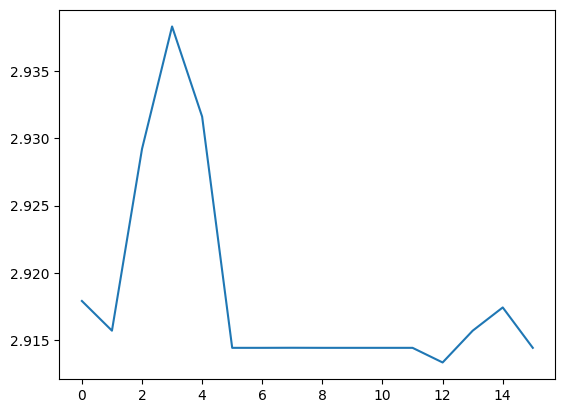

In [ ]:
plt.plot([ model.metrics[epoch]['devMetrics']['loss'] for epoch in model.metrics ])
plt.show()

In [ ]:
import pickle 

pickle.dump(model.metrics, open('metrics.pkl', 'wb'))